In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
from plot_utils import *
import models
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext skip_kernel_extension
%load_ext autoreload
%autoreload 2

In [2]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

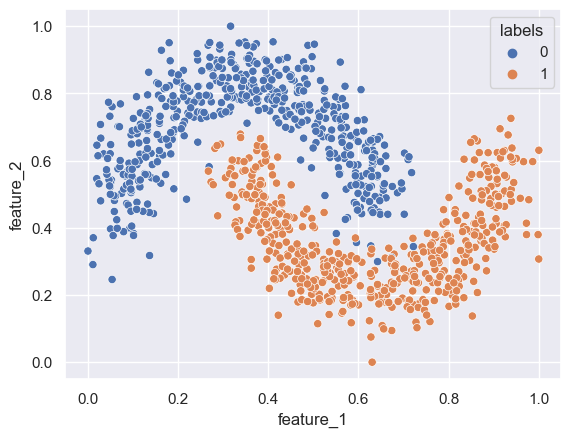

In [3]:
sns.set_theme()
def moons_scatter(ax=None):
    if ax:
        sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels, ax=ax)
    else:
        sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)
moons_scatter()

In [4]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
zs = gmm.find_solution(data,iterate=True, collect_z=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [5]:
df2 = pd.DataFrame(gmm.mu.detach(), columns=['feature_1', 'feature_2'])
df2['labels'] = ['gmm_center']*n_centers

In [6]:
# make grid for contour
x = y = np.arange(-.03, 1.03, 0.01)
points = []
for xx in x:
    for yy in y:
        points.append([xx, yy])

<Axes: xlabel='feature_1', ylabel='feature_2'>

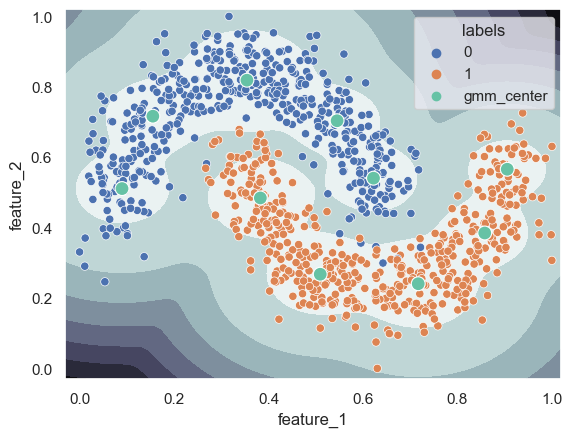

In [7]:
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
plt.contourf(x,y,z, cmap=plt.cm.bone)
moons_scatter()
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

In [8]:
%%skip True
animate_em(zs,x,y,df)

### MLP Classifier

In [9]:
label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

In [10]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
loss = []
acc = []
optimizer = optim.Adam(param_groups)

for epoch in range(200):
    
    l,a,_= tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    loss.append(l)
    acc.append(a)
    if a > .98:
        break # converged

Text(0.5, 0, 'Epoch')

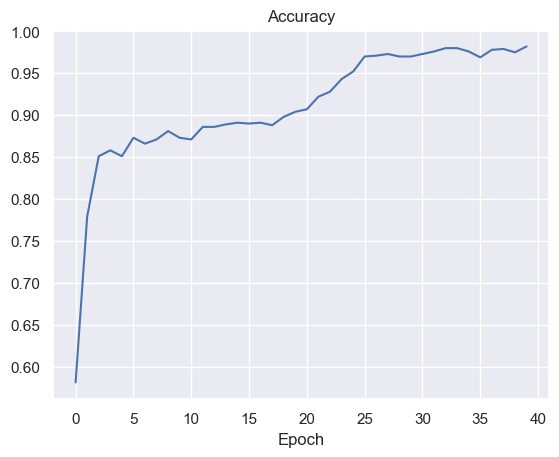

In [11]:
sns.lineplot(acc)
plt.title('Accuracy')
plt.xlabel('Epoch')

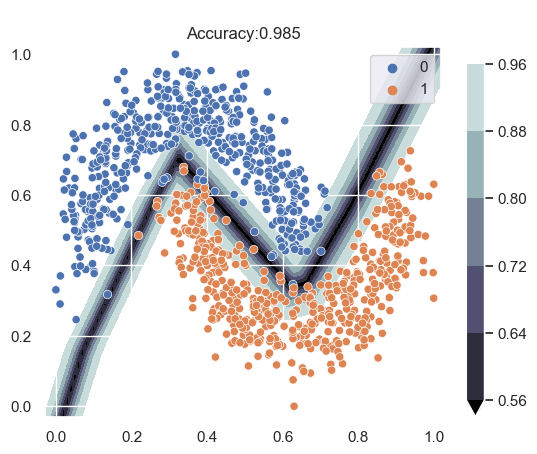

In [12]:
plot_conf(net, data, label, device=device)

### CCU Robust Model Learning

In [13]:
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [14]:
data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000, dtype=torch.int64)


train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)

In [15]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

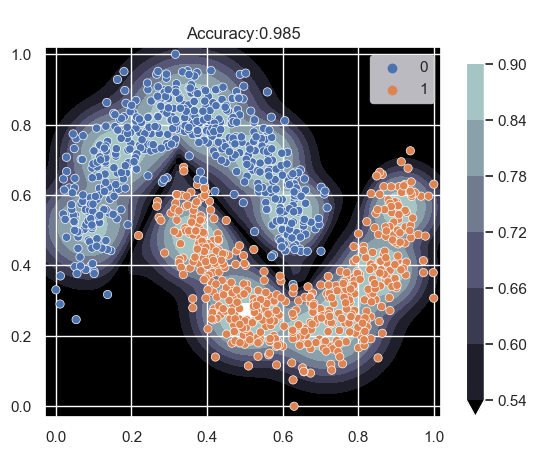

In [16]:
plot_conf(CCU.to(device), data, label, device=device)

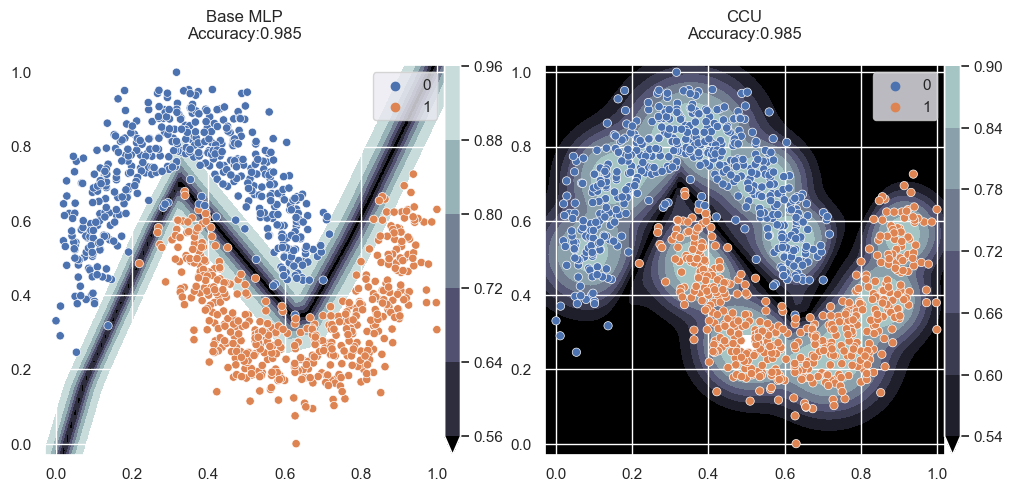

In [17]:
#%%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')

# plt.savefig('Base_Vs._CCU_Confidence.png')

In [18]:
gmm.mu.requires_grad_(False) # turn of learning of centers
for epoch in range(100):
    tt.train_CEDA_gmm(CCU, device, train_loader,
                      optimizer, epoch, verbose=-1,
                      noise_loader=train_loader_out)

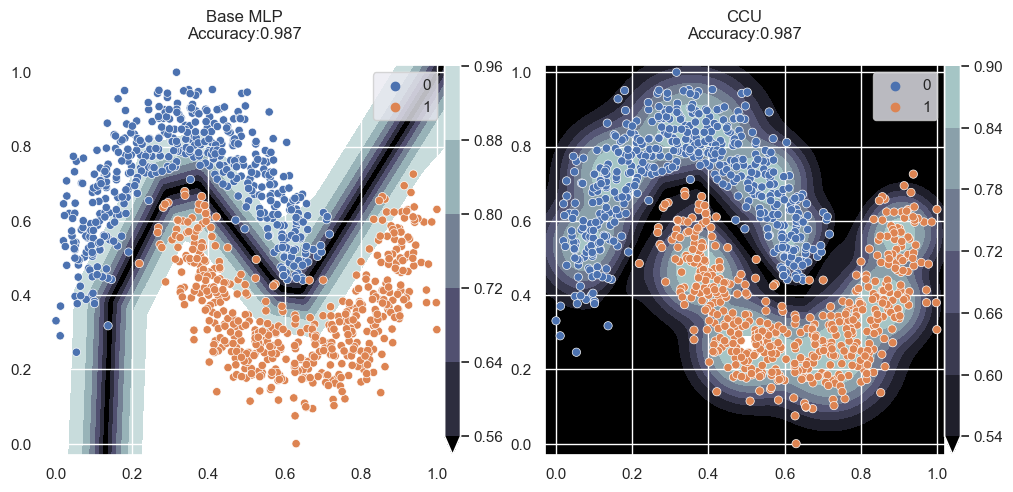

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')

## RBFNet Classifier

In [20]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x, p=2, dim=-1):
    return torch.norm(x, p=p, dim=dim)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=10,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [21]:
lr = 0.1
decay = 5e-4

RBFnet = TwoMoonsRBFNet()
param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(RBFnet.rbf)]
for epoch in range(100):
    loss,acc,_ = tt.train_plain(RBFnet.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
    if acc > .98:
        print('Done training at EPOCH:',epoch)
        break

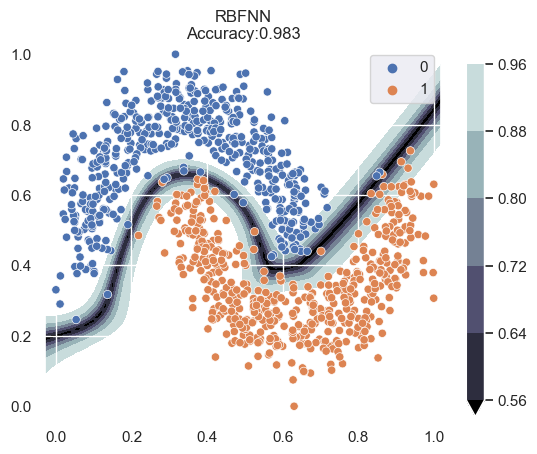

In [22]:
# %%skip True
plot_conf(RBFnet, data, label, device=device, title='RBFNN')
# plt.savefig('RBFNN_conf.png')

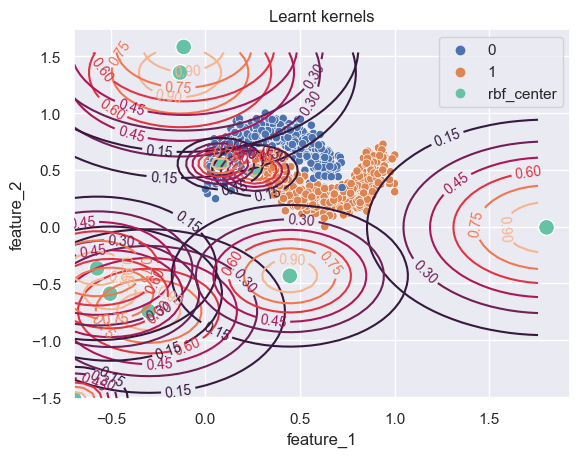

In [23]:
kernel_map(RBFnet.rbf, df)

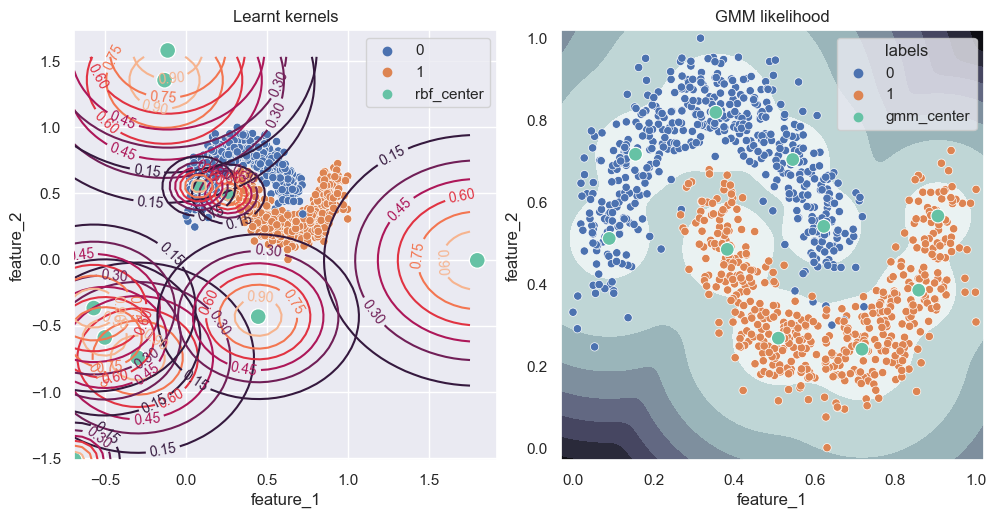

In [24]:
# %%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.95,left=.08,wspace=.15,right=.99)
kernel_map(RBFnet.rbf, df, ax = ax1)
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
cont = ax2.contourf(x,y,z, cmap=plt.cm.bone)
#sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels', ax = ax2)
moons_scatter(ax2)
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100, ax = ax2)
ax2.title.set_text(f'GMM likelihood')
# plt.savefig('RBF_Vs_GMM_Centers.png')

In [25]:
%%skip True
animate_rbf(rbf_tracker, df)

## RBF with CCU (with GMM and RBF seperate)

In [26]:
RBFCCU = models.RobustModel(deepcopy(RBFnet.to(device)), deepcopy(gmm.to(device)), 0.0, dim=2,classes=2)

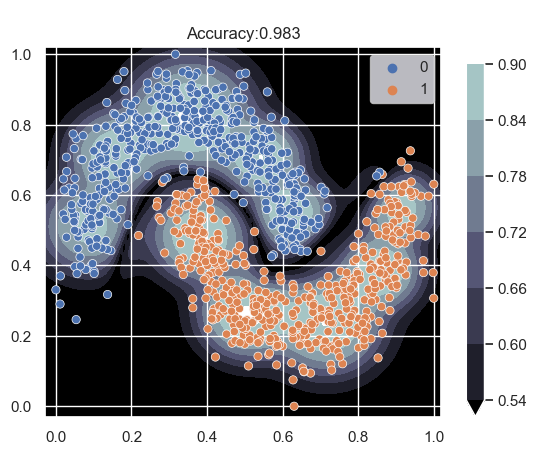

In [27]:
plot_conf(RBFCCU,data, label, device=device)

In [28]:
lr_gmm = 1e-4
param_groups = [{'params':RBFCCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':RBFCCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

In [29]:
gmm.mu.requires_grad_(False) # turn of learning of centers
for epoch in range(100):
    tt.train_CEDA_gmm(RBFCCU, device, train_loader,
                      optimizer, epoch, verbose=-1,
                      noise_loader=train_loader_out)

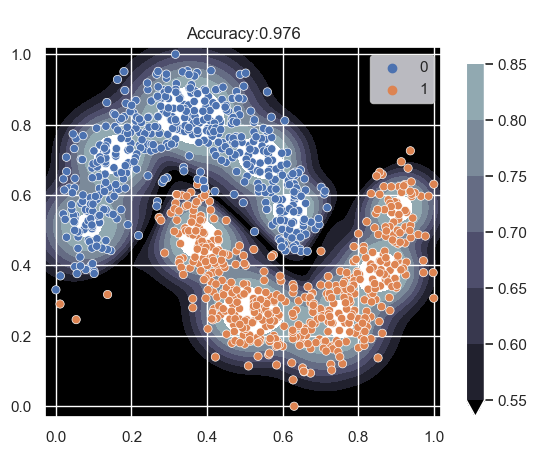

In [30]:
plot_conf(RBFCCU,data, label, device=device)

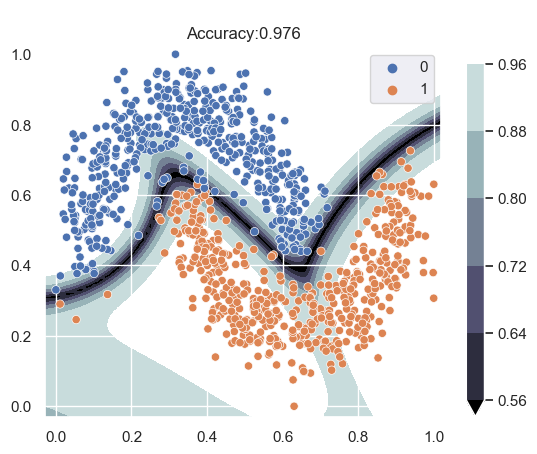

In [31]:
plot_conf(RBFCCU.base_model,data, label, device=device)

### Compare RBF output to GMM output

In [32]:
sample = torch.tensor([[.4,.4],[.7,.8]])
RBFnet.to('cpu')
gmm.to('cpu')

GMM(
  (metric): LpMetric()
)

In [33]:
RBFnet.rbf(sample) # rbf has 10 centers, gives distance from each center row wise

tensor([[-0.1458,  0.0635, -1.4352, -0.4199,  1.0851, -0.0207, -0.8381,  0.0061,
          1.1101, -0.3134],
        [-0.0037, -0.0223, -0.3676,  0.7176, -0.2862, -0.0130, -0.0605,  1.4402,
         -0.2322, -0.6688]], grad_fn=<SumBackward1>)

In [34]:
rc = RBFnet.rbf.get_kernels_centers
rvar = RBFnet.rbf.get_shapes
rw = RBFnet.rbf.get_weights

In [35]:
RBFnet.rbf(rc)

tensor([[ 1.8419e-03, -1.4361e-02,  7.4159e-02, -1.1766e-01,  5.8927e-02,
         -5.6732e-03, -1.0927e-02, -5.5705e-02,  4.8447e-02,  9.9153e-02],
        [-2.1429e-04, -2.2620e-03,  3.4050e-01,  8.7678e-02,  4.0419e-01,
          9.9089e-04, -7.2179e-02, -3.0257e-01,  4.0357e-01,  4.8588e-01],
        [-1.7534e-03,  3.1901e-02, -5.4613e-01,  8.9674e-01, -2.2497e-01,
         -5.9803e-03, -1.3601e-01,  1.5668e+00, -1.5862e-01, -8.2452e-01],
        [ 7.1744e-03,  3.5068e-02, -5.1554e-01,  8.8963e-01, -2.2558e-01,
         -1.9366e-03, -1.3140e-01,  1.5663e+00, -1.5825e-01, -7.9319e-01],
        [-1.2580e-01,  2.3380e-01, -1.4302e+00, -2.2143e-01,  8.8744e-01,
         -2.1021e-02, -7.9497e-01,  2.2414e-01,  8.8506e-01, -3.3957e-01],
        [ 3.4440e-03, -1.2039e-02,  6.0622e-02, -6.2715e-02,  3.3975e-04,
         -6.1355e-03, -2.4042e-03, -5.0363e-02, -6.5119e-03,  8.1482e-02],
        [ 1.4619e-01, -4.2882e-01,  1.7158e+00, -9.2656e-01, -8.6038e-01,
          2.3181e-03,  6.8579e-0

In [36]:
rc

tensor([[-0.3002, -0.7430],
        [-0.6932, -1.5166],
        [-0.1336,  1.3567],
        [-0.1145,  1.5817],
        [ 0.2613,  0.4939],
        [-0.5034, -0.5897],
        [ 1.8017, -0.0064],
        [-0.5721, -0.3673],
        [ 0.0786,  0.5544],
        [ 0.4459, -0.4323]])

In [37]:
gmm(sample)# gmm has 10 centers, gives value in column for likelihood of each point from sample

tensor([[-50.3009, -16.4686],
        [-11.3506,  -7.1926],
        [-10.1862, -27.4596],
        [-10.3878, -46.8244],
        [-10.8615, -11.6380],
        [  0.5214, -23.8238],
        [-18.2442,  -4.3853],
        [-33.0011, -30.9803],
        [ -2.0644, -37.5225],
        [-19.6730, -38.4401]], grad_fn=<SubBackward0>)

In [38]:
gc = gmm.mu.detach()
gvar = gmm.logvar.detach()
gw = gmm.alpha.detach()

In [39]:
gvar.exp()

tensor([0.0027, 0.0069, 0.0054, 0.0048, 0.0028, 0.0040, 0.0029, 0.0031, 0.0041,
        0.0038])

In [40]:
gw.exp()

tensor([0.0573, 0.1872, 0.1400, 0.0807, 0.0786, 0.1067, 0.0719, 0.0741, 0.1203,
        0.0832])

In [41]:
rvar

tensor([1.9150, 4.9145, 1.4847, 1.4924, 6.1882, 2.3363, 1.4527, 2.1844, 6.1112,
        2.2121])

In [42]:
rw.exp()

tensor([[1.0000, 0.9997, 0.9264, 1.0853, 0.8138, 1.0018, 1.1574, 1.0094, 1.1193,
         0.9805],
        [0.9945, 0.9983, 1.0054, 1.0635, 1.0736, 0.9470, 0.6513, 1.0364, 2.9062,
         1.0185],
        [1.0854, 1.4325, 0.4484, 0.7714, 0.1384, 1.0789, 5.5618, 1.0150, 1.0085,
         1.4520],
        [0.7610, 1.1174, 2.6020, 2.2935, 0.4292, 1.0399, 0.3959, 1.0226, 4.1105,
         0.7889],
        [1.1788, 1.5282, 0.8026, 0.7940, 4.6766, 0.8804, 0.4230, 0.9791, 0.4174,
         3.9624],
        [0.9963, 1.0014, 0.9610, 1.0324, 0.9776, 0.9920, 1.0023, 0.9939, 0.9839,
         0.9911],
        [1.0045, 0.9253, 0.8399, 0.9113, 0.3244, 0.9998, 1.9855, 0.9966, 0.9989,
         0.5283],
        [0.9724, 0.7246, 4.8118, 4.7686, 0.6466, 0.9236, 1.4810, 0.9717, 6.5413,
         0.5690],
        [1.1443, 1.5301, 0.8507, 0.8563, 4.6922, 0.8739, 0.4080, 0.9935, 0.3839,
         4.7872],
        [1.0878, 1.6735, 0.3374, 0.5880, 0.7291, 1.1088, 3.3626, 1.0398, 0.9259,
         2.5147]])

In [44]:
gc

tensor([[0.9053, 0.5658],
        [0.3543, 0.8188],
        [0.7169, 0.2405],
        [0.0899, 0.5109],
        [0.6222, 0.5404],
        [0.3827, 0.4843],
        [0.5452, 0.7036],
        [0.8577, 0.3847],
        [0.5095, 0.2675],
        [0.1551, 0.7165]])

In [45]:
rc

tensor([[-0.3002, -0.7430],
        [-0.6932, -1.5166],
        [-0.1336,  1.3567],
        [-0.1145,  1.5817],
        [ 0.2613,  0.4939],
        [-0.5034, -0.5897],
        [ 1.8017, -0.0064],
        [-0.5721, -0.3673],
        [ 0.0786,  0.5544],
        [ 0.4459, -0.4323]])

<Axes: xlabel='feature_1', ylabel='feature_2'>

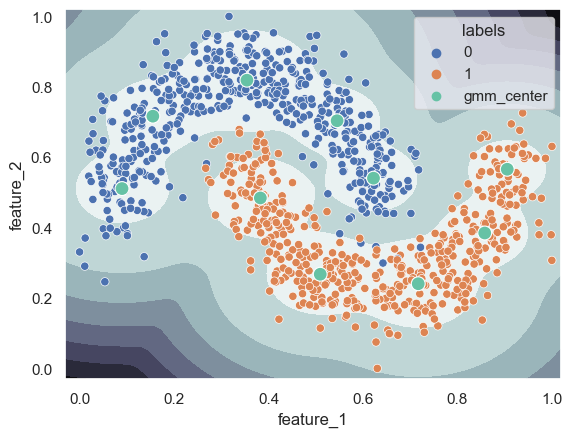

In [43]:
plt.contourf(x,y,z, cmap=plt.cm.bone)
moons_scatter()
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

### Combine RBF and GMM centers

In [49]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [50]:
class TwoMoonsRBFNet(nn.Module):
    def __init__(self, centers=None, n_centers=10):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=n_centers,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True,
                           initial_centers_parameter=centers, # input gmm centers
                           constant_centers_parameter=True) # do not learn centers
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [56]:
lr = 0.1
decay = 5e-4

RBFnet = TwoMoonsRBFNet(centers=gmm.mu.data)
param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(RBFnet.rbf)]
for epoch in range(150):
    loss,acc,_ = tt.train_plain(RBFnet.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
    # if acc > .98:
    #     print('Done training at EPOCH:',epoch)
    #     break

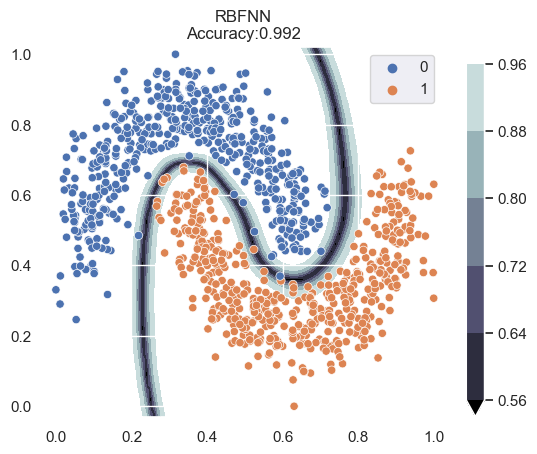

In [57]:
plot_conf(RBFnet, data, label, device=device, title='RBFNN')

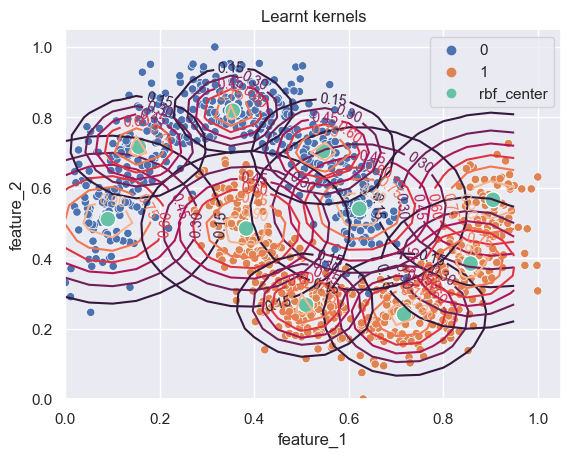

In [58]:
kernel_map(RBFnet.rbf, df)

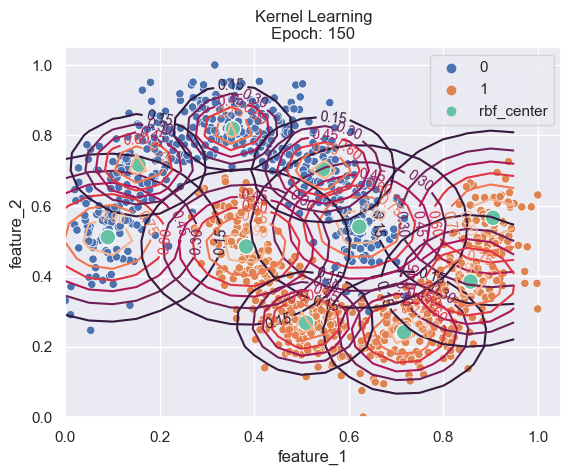

In [63]:
%%skip True
animate_rbf(rbfs=rbf_tracker,
            df=df,
            title='_GMM_centers')

### Replace RBF outputs with GMM outputs

In [64]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [67]:
gmm(data[:2])

tensor([[-44.1335, -52.3668],
        [  0.5611,  -8.3042],
        [-29.4037, -13.4595],
        [-17.8900,  -7.9113],
        [-12.1321, -10.8359],
        [ -7.8060,   1.3129],
        [ -0.8496, -14.6376],
        [-48.7911, -37.5319],
        [-27.3194,  -4.8006],
        [ -9.5794, -14.2439]], grad_fn=<SubBackward0>)

10

In [76]:
class RobustGMM(nn.Module):
    def __init__(self, gmm,  loglam=0, dim=2, classes=2):
        super().__init__()
        self.gmm = gmm
        self.dim = dim
        self.loglam = nn.Parameter(torch.tensor(loglam, dtype=torch.float), requires_grad=False)
        self.log_K = nn.Parameter(-torch.tensor(classes, dtype=torch.float).log(), requires_grad=False)
        self.fc1 = nn.Linear(gmm.mu.shape[0], classes) # pull number of centers down to binary class
        
    def forward(self, x):
        batch_size = x.shape[0]
        gmm_out = self.gmm(x.view(batch_size, self.dim)) # don't need activation (GMM is non-linear)
        like = torch.logsumexp(gmm_out, dim=0)
        x = F.log_softmax(self.fc1(gmm_out), dim=1) # output of (GMM/RBF)
        ## CCU mode on model output
        a1 = torch.stack((x + like[:, None], (self.loglam + self.log_K) * torch.ones_like(x)), 0)
        b1 = torch.logsumexp(a1, 0).squeeze()

        a2 = torch.stack((like, (self.loglam) * torch.ones_like(like)), 0)
        b2 = torch.logsumexp(a2, 0).squeeze()[:, None]

        return b1 - b2 
device=torch.device('cuda:0')

In [78]:
gmm.mu.requires_grad_(False) # turn of learning of centers
Rgmm = RobustGMM(gmm)

In [79]:
Rgmm(data)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [77]:
lr = 0.1
decay = 5e-4


param_groups = [{'params':Rgmm.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)

for epoch in range(350):
    loss,acc,_ = tt.train_plain(Rgmm.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    
    if acc > .98:
        print('Done training at EPOCH:',epoch)
        break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x250 and 10x2)